# Siamese Network

This notebook explores creating a Siamese Network with a triplet-loss function to attempt to differentiate the images.

To do:

1. Build a Dataset that returns a single triplet of images.
2. Build a Dataloader for it too.
3. Construct a loss function.

In [199]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from collections import defaultdict

from PIL import Image
import pandas as pd
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from matplotlib import pyplot as plt

In [37]:
def ceildiv(a, b):
    return -(-a // b)

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None, maintitle=None):
    """Function for plotting a bunch of images from fastai."""
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims)
        if (ims.shape[-1] != 3): ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    if maintitle is not None:
        plt.suptitle(maintitle, fontsize=16)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, ceildiv(len(ims), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [38]:
PATH = 'data/'

In [39]:
df = pd.read_csv(f'{PATH}train.csv')

In [136]:
def load_image(filepath, input_shape):
    im = Image.open((filepath)).convert('RGB')
    im = im.resize(input_shape)

    return np.array(im, dtype=np.float32)


class TripletDataset(Dataset):

    def __init__(self, df, transform=None, seed=42, img_shape=(224, 224)):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = df
        self.transform = transform
        
        self.landmark_id_to_img_ids = defaultdict(list)
        for landmark_id, img_id in zip(df.landmark_id.values, df.id.values):
            self.landmark_id_to_img_ids[landmark_id].append(img_id)
            
        self.all_landmarks = list(self.landmark_id_to_img_ids.keys())
        class_sizes = np.array([
            len(self.landmark_id_to_img_ids[landmark]) for landmark in self.all_landmarks])
        self.class_weights = class_sizes / np.sum(class_sizes)
        
        self.img_shape = img_shape
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        """
        Walk through the dataset. For each image, find another image from the same
        class, called positive, then find an image from another class negative.
        
        Perform transforms on each of the returned images.
        """
        # Get a random class based on the distribution of images per class.
        # This ensures we're less likely to get classes with only 1 image.
        anchor_img = positive_img = None
        
        row = self.df[self.df.index == idx]
        
        anchor_id = row.id.values[0]
        landmark_id = row.landmark_id.values[0]
        
        anchor_img = np.array(Image.open(f'{PATH}train/{anchor_id}.jpg').resize(self.img_shape))
        
        positive_img = None
        
        # Get 2 random images from the class.
        other_imgs = self.landmark_id_to_img_ids[landmark_id]
        
        while positive_img is None:
            positive_id = np.random.choice(other_imgs, 1)[0]
            
            try:
                positive_img = np.array(Image.open(f'{PATH}train/{positive_id}.jpg').resize(self.img_shape))
            except (FileNotFoundError, OSError):
                continue

        # Get a negative example, ensuring it's not from the class.
        negative_img = None
        while negative_img is None:
            other_landmark_id = np.random.choice(self.all_landmarks, 1, p=self.class_weights)[0]
            if other_landmark_id == landmark_id:
                continue

            imgs = self.landmark_id_to_img_ids[landmark_id]
            negative_id = np.random.choice(self.landmark_id_to_img_ids[other_landmark_id], 1)[0]
            try:
                negative_img = np.array(Image.open(f'{PATH}train/{negative_id}.jpg').resize(self.img_shape))     
            except FileNotFoundError:
                continue
        
        # Return a tuple of anchor, positive, negative
        return np.array([anchor_img, positive_img, negative_img])

In [137]:
len(df)

1225029

In [138]:
dataset = TripletDataset(df)

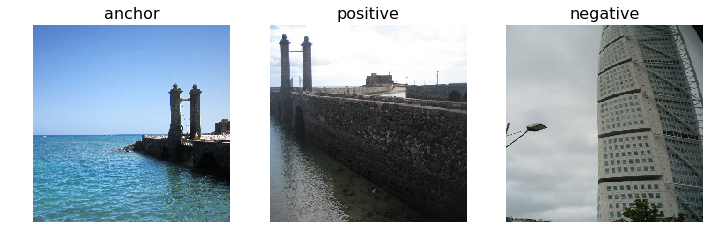

In [139]:
plots(dataset[0], titles=['anchor', 'positive', 'negative'])

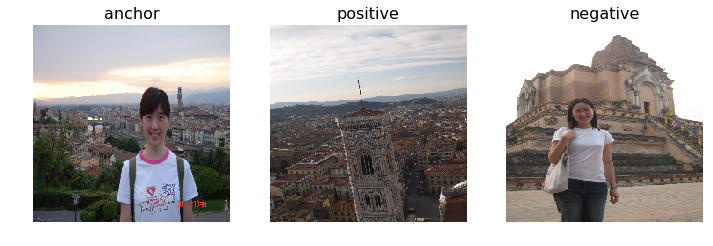

In [140]:
plots(dataset[1], titles=['anchor', 'positive', 'negative'])

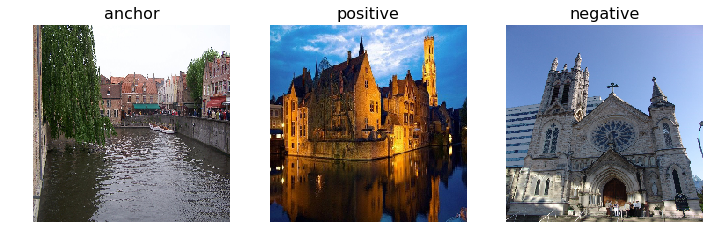

In [141]:
plots(dataset[1000], titles=['anchor', 'positive', 'negative'])

In [142]:
from torch.utils.data import DataLoader

dl = DataLoader(dataset, batch_size=4, shuffle=True)

In [143]:
triplet = next(iter(dl))

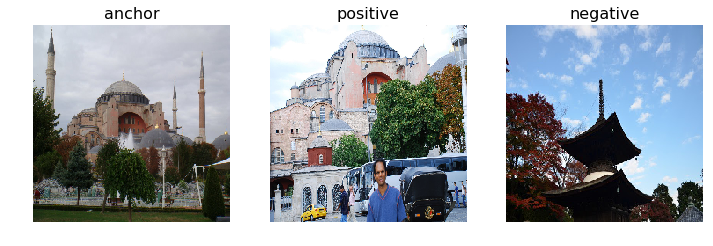

In [147]:
plots(triplet[0], titles=['anchor', 'positive', 'negative'])

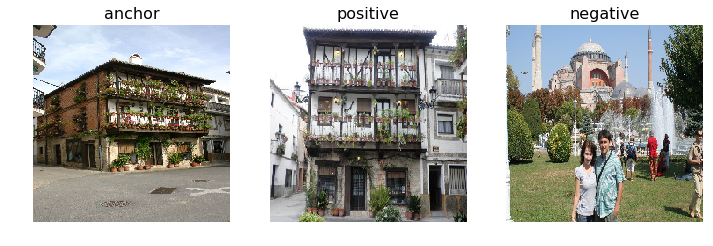

In [149]:
plots(triplet[1], titles=['anchor', 'positive', 'negative'])

In [156]:
from torchvision import models
from torch import nn

In [161]:
latent_dim = 128

Want to load ResNet50, then replace the final layers with a fully-connected layer with some number of latent factors.

In [162]:
resnet50 = models.resnet50(pretrained=False)

In [163]:
resnet50.fc = nn.Linear(512 * models.resnet.Bottleneck.expansion, latent_dim)

In [204]:
class SiameseNet(nn.Module):
    
    """WIP: SiameseNetwork."""
    
    def __init__(self):
        super(SiameseNet, self).__init__()
        
        self.base_model = models.resnet50(pretrained=False)
        self.base_model.fc = nn.Linear(512 * models.resnet.Bottleneck.expansion, latent_dim)
        
    def forward(self, inputs):
        anchor, primary, negative = inputs
        
        anchor_out = self.base_model.forward(anchor[None])
        primary_out = self.base_model.forward(primary[None])
        negative_out = self.base_model.forward(negative[None])
        
        pos_distance = (anchor_out - primary_out).sum(1)
        neg_distance = (anchor_out - negative_out).sum(1)
        
        loss = pos_distance - neg_distance + alpha
        
        output = torch.max(loss, 0)
        
        return output

In [205]:
model = SiameseNet()

In [ ]:
output = model(Variable(triplet[0]))

Things to figure out:

* What should `forward` return?
* What are `Variable`s?
* Best practises for models within models.